In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
import numpy as np
import time

Using TensorFlow backend.


In [0]:
#parameters
epsilon = 0.01  #the quantity of perturbation we add to the images
step_pgd = 20   #the number of steps taken during the PGD algo
eta = 0.005     #used in PGD algo

#parameters

epsilon_l2 = 0.4  #the quantity of perturbation we add to the images norm L2
epsilon_inf = 0.031 #norm infini

step_pgd = 20   #the number of steps taken during the PGD algo
eta_l2 = 0.4     #used in PGD algo
eta_inf = 0.031

In [0]:
labels = ["airplane","automobile"	,"bird","cat","deer","dog","frog"	,"horse","ship","truck"]

# Data

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

170500096/170498071 [==============================] - 2s 0us/step


# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
history = adversarial.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 10s 250us/sample - loss: 1.6717 - accuracy: 0.4078 - val_loss: 1.4166 - val_accuracy: 0.5069
Epoch 2/10
40000/40000 [==============================] - 3s 76us/sample - loss: 1.3432 - accuracy: 0.5275 - val_loss: 1.2972 - val_accuracy: 0.5453
Epoch 3/10
40000/40000 [==============================] - 3s 76us/sample - loss: 1.2452 - accuracy: 0.5659 - val_loss: 1.2449 - val_accuracy: 0.5702
Epoch 4/10
40000/40000 [==============================] - 3s 79us/sample - loss: 1.1789 - accuracy: 0.5905 - val_loss: 1.1787 - val_accuracy: 0.5982
Epoch 5/10
40000/40000 [==============================] - 3s 85us/sample - loss: 1.1298 - accuracy: 0.6108 - val_loss: 1.1961 - val_accuracy: 0.5896
Epoch 6/10
40000/40000 [==============================] - 3s 83us/sample - loss: 1.0783 - accuracy: 0.6246 - val_loss: 1.1259 - val_accuracy: 0.6157
Epoch 7/10
40000/40000 [==============================

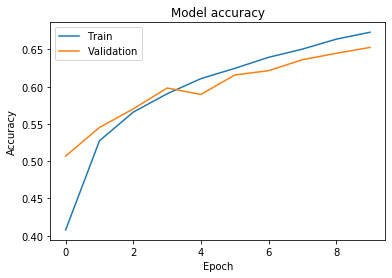

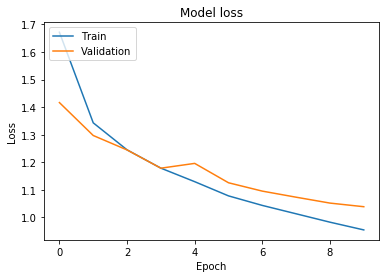

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Perturbations (FGM, FGSM)

In [0]:
#create the perturbations on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations_inf = tf.sign(gradient).numpy()*epsilon_inf 

perturbations_l2 = np.zeros((len(x_test),32,32,3))
for i in range(len(x_test)):
  perturbations_l2[i]=(epsilon_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

x_test_fgsm = x_test + perturbations_inf
x_test_fgm = x_test + perturbations_l2

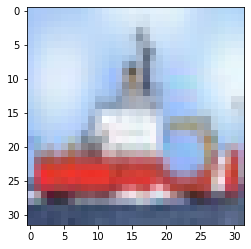

Prediction (Orginal image) :  ship


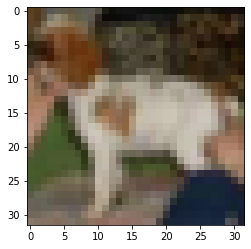

Prediction (Orginal image) :  dog


In [10]:
# print the original image
plt.imshow(x_test[92].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test[92]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (Orginal image) : ", labels[label])

plt.imshow(x_test[12].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test[12]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (Orginal image) : " ,labels[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


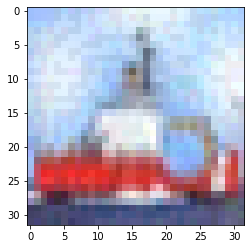

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction (FGSM) :  automobile


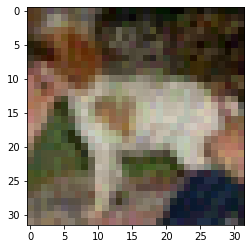

Prediction (FGSM) :  frog


In [11]:
#the modified image (FGSM)
plt.imshow(x_test_fgsm[92].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test_fgsm[92]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (FGSM) : ", labels[label])

plt.imshow(x_test_fgsm[12].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test_fgsm[12]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (FGSM) : ", labels[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


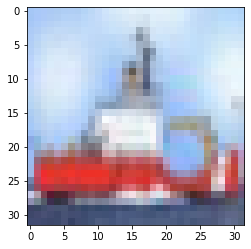

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction (FGM) :  ship


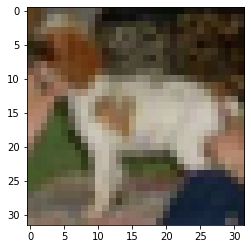

Prediction (FGM) :  cat


In [12]:
#the modified image (FGM)
plt.imshow(x_test_fgm[92].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test_fgm[92]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (FGM) : ", labels[label])

plt.imshow(x_test_fgm[12].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test_fgm[12]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (FGM) : ", labels[label])

In [13]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/10000 [==============================] - 1s 95us/sample - loss: 1.0250 - accuracy: 0.6511
[1.0250389655113221, 0.6511]


In [14]:
#results for the modified image
print(adversarial.evaluate(x_test_fgsm, y_test))
print(adversarial.evaluate(x_test_fgm, y_test))

10000/10000 [==============================] - 1s 96us/sample - loss: 4.9701 - accuracy: 0.0216
[4.970075944519043, 0.0216]
10000/10000 [==============================] - 1s 98us/sample - loss: 2.1207 - accuracy: 0.2797
[2.120680867385864, 0.2797]


 est-ce qu'on fait #create the perturbations for TRAINING SET   ?

# Perturbations (PGD en norme infinie)

In [0]:
#create the perturbations
#Norme infinie 

x_test_pgd_inf = np.copy(x_test)
x_train_pgd_inf = np.copy(x_train[:10000,:,:,:])
image_ref = tf.cast(x_test, tf.float32)
image_ref_train = tf.cast(x_train[:10000,:,:,:], tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd_inf, tf.float32)
  image_train =  tf.cast(x_train_pgd_inf, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
  
  perturbations_inf = tf.sign(gradient).numpy()*eta_inf
  x_test_pgd_inf = x_test_pgd_inf + perturbations_inf
  x_train_pgd_inf = x_train_pgd_inf + perturbations_inf  
  x_test_pgd_inf = np.maximum(np.minimum(x_test_pgd_inf, x_test + epsilon), x_test - epsilon)
  x_train_pgd_inf = np.maximum(np.minimum(x_train_pgd_inf, x_test + epsilon), x_train[:10000,:,:,:] - epsilon)

In [0]:
#Norme L2

x_test_pgd_l2 = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)

for step in range(step_pgd):
  image = tf.cast(x_test_pgd_l2, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
  
  gradient = tape.gradient(loss,image)

  perturbations_l2 = np.zeros((len(x_test),32,32,3))
  for i in range(len(x_test_pgd_l2)):
    perturbations_l2[i]=(eta_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

  x_test_pgd_l2 = x_test_pgd_l2 + perturbations_l2
  x_test_pgd_l2 = np.maximum(np.minimum(x_test_pgd_l2,x_test + epsilon),x_test - epsilon)

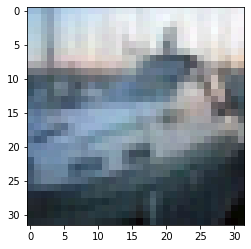

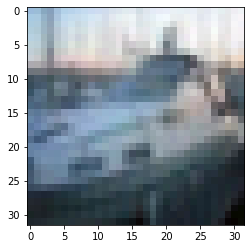

In [26]:
#the modified image (PGD)

#Norme Inf
plt.imshow(x_test_pgd_inf[2].reshape((32, 32, 3)))
plt.show()

#Norme L2
plt.imshow(x_test_pgd_l2[2].reshape((32, 32, 3)))
plt.show()

In [27]:
#Norme Inf 
print(adversarial.evaluate(x_test_pgd_inf, y_test))

#Norme L2 
print(adversarial.evaluate(x_test_pgd_l2, y_test))

10000/10000 [==============================] - 1s 85us/sample - loss: 2.0361 - accuracy: 0.2517
[2.036129531097412, 0.2517]
10000/10000 [==============================] - 1s 87us/sample - loss: 2.2434 - accuracy: 0.2148
[2.243449988937378, 0.2148]


# Adversarial training

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial_trained = keras.models.Model(inputs=input, outputs=x)
adversarial_trained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
#boucle
nb_ex_modif = 13000
epochs = 10
x_train_adv_pgd = np.copy(x_train)
y_train_adv_pgd = np.copy(y_train)
histories = [0 for i in range(epochs)]
#training with the modified training set 
for i in range (epochs):
    histories[i] = adversarial_trained.fit(x_train_adv_pgd, y_train_adv_pgd, batch_size=64, epochs=1, validation_split=0.2)

    image = tf.cast(x_train_adv_pgd[:nb_ex_modif, :, :, :], tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = adversarial_trained(image)
      loss = tf.keras.losses.MSE(y_train_adv_pgd[:nb_ex_modif], prediction)

    gradient = tape.gradient(loss, image)
    perturbations = tf.sign(gradient).numpy()
    x_train_adv_pgd[:nb_ex_modif, :, :, :] = x_train_adv_pgd[:nb_ex_modif, :, :, :] + perturbations * eta
    x_train_adv_pgd[:nb_ex_modif, :, :, :] = np.maximum(np.minimum(x_train_adv_pgd[:nb_ex_modif, :, :, :], x_train[:nb_ex_modif, :, :, :] + epsilon), x_train[:nb_ex_modif, :, :, :] - epsilon)


Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 4s 91us/sample - loss: 1.6937 - accuracy: 0.3972 - val_loss: 1.4578 - val_accuracy: 0.4879
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 76us/sample - loss: 1.4348 - accuracy: 0.4873 - val_loss: 1.3609 - val_accuracy: 0.5191
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 74us/sample - loss: 1.3975 - accuracy: 0.5019 - val_loss: 1.2572 - val_accuracy: 0.5746
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 76us/sample - loss: 1.3391 - accuracy: 0.5205 - val_loss: 1.1986 - val_accuracy: 0.5973
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 77us/sample - loss: 1.3000 - accuracy: 0.5388 - val_loss: 1.1717 - val_accuracy: 0.6053
Train on 40000 samples, validate on 10000 samples
40000/4000

In [17]:
#results for the original image
print(adversarial_trained.evaluate(x_test, y_test))
print(adversarial_trained.evaluate(x_test_fgsm, y_test))

10000/10000 [==============================] - 1s 96us/sample - loss: 1.1094 - accuracy: 0.6162
[1.109411365890503, 0.6162]
10000/10000 [==============================] - 1s 98us/sample - loss: 2.3984 - accuracy: 0.2107
[2.3983653900146487, 0.2107]


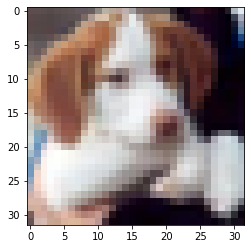

[[0.    0.002 0.017 0.148 0.    0.761 0.006 0.061 0.001 0.003]]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [18]:
plt.imshow(x_test[16].reshape((32,32,3)))
plt.show()
print(np.around(adversarial.predict(np.reshape(x_test[16],[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False), decimals=3))
print(labels) 

# Black box

In [0]:
def gen_perturbations_show(img,label,eps,maxpert):
  fiximg = img
  plt.imshow(img.reshape((32,32,3)))
  plt.show()
  pred = np.argmax(adversarial.predict(np.reshape(img,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]
  print(labels[pred])
  score = 1
  scores = []
  while (pred == np.argmax(label)) :
    #rand_pert = np.random.randint(-1,2,size=[32,32,3])*eps
    rand_pert = np.random.normal(0,1,size=[32,32,3])*eps
    new_img = img + rand_pert
    tablepred  = adversarial.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    pred = np.argmax(tablepred,axis =1 )[0]
    if (tablepred[0][pred]<score) :
      img = new_img
      score = tablepred[0][pred]
      scores.append(score)
    pertsize = np.linalg.norm(fiximg-new_img)
    if (pertsize>maxpert):
      print('ON SELOIGNE TROP')
      return('Pas trouvé')
  if (score!=1):
    print(labels[np.argmax(adversarial.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]])
    plt.imshow(new_img.reshape((32,32,3)))
  else : 
    print(labels[np.argmax(adversarial.predict(img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]])
    plt.imshow(img.reshape((32,32,3)))
  plt.show()
  return(new_img,scores,pertsize)

In [0]:
def gen_perturbations_process(img,label,eps,maxpert):
  fiximg = img
  pred = np.argmax(adversarial.predict(np.reshape(img,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]
  score = 1
  scores = []
  while (pred == np.argmax(label)) :
    rand_pert = np.random.normal(0,1,size=[32,32,3])*eps
    new_img = img + rand_pert
    tablepred  = adversarial.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    pred = np.argmax(tablepred,axis =1 )[0]
    if (tablepred[0][pred]<score) :
      img = new_img
      score = tablepred[0][pred]
      scores.append(score)
    pertsize = np.linalg.norm(fiximg-new_img)
    if (pertsize>maxpert):
      print('ON SELOIGNE TROP')
      return(img,scores,0)
  if (score==1):
    return(img,scores,0)
  return(new_img,scores,pertsize)

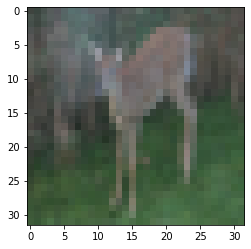

deer
horse


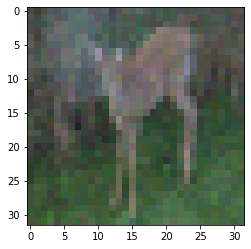

1.9968163967132568


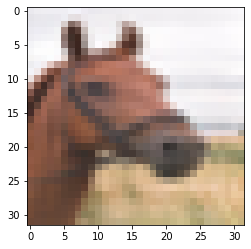

horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


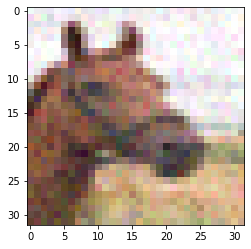

7.377289533615112


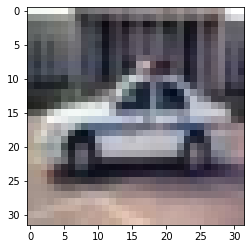

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


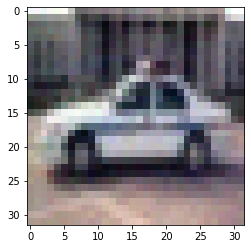

8.253785610198975


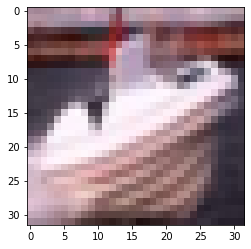

ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


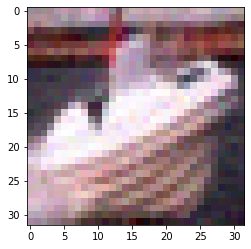

10.188180923461914


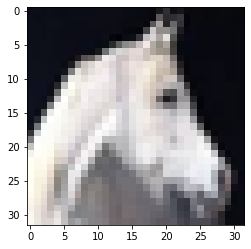

dog
dog


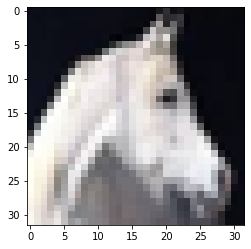

UnboundLocalError: ignored

In [21]:
t = time.time()
tot = 0
idxcool = [0,5,10,14,15]
#for i in range(20):
for i in idxcool:
  gen_perturbations_show(np.reshape(x_test[94+i,:,:,:],[1,32,32,3]),y_test[94+i],0.005,3)
  print(time.time()-t)

In [0]:
t = time.time()
tot = 0
x_pert = np.zeros((1000,32,32,3))
for i in range(1000):
  x_pert[i]= gen_perturbations_process(np.reshape(x_test[i,:,:,:],[1,32,32,3]),y_test[i],0.005,3)[0]
  print(time.time()-t)

In [28]:
print(adversarial_trained.evaluate(np.reshape(x_pert,[1000,32,32,3]), y_test[:1000]))

1000/1000 [==============================] - 0s 97us/sample - loss: 3.3880 - accuracy: 0.1200
[3.38797749710083, 0.12]


In [0]:
def pixel(img,label):
  wrong_class = 0
  print(labels[np.argmax(label)])
  plt.imshow(img.reshape((32,32,3)))    
  plt.show()  
  for i in range(32*32):
    pix = np.zeros(32*32)
    pix[i] = 1 
    pix = np.reshape(pix,[1,32,32])
    pert = np.concatenate((pix,pix,pix),axis=0).T
    testpix = img + pert
    tablepred = adversarial_trained.predict(np.reshape(testpix,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False) 
    pred = np.argmax(tablepred,axis =1 )[0]
    if(pred!=np.argmax(label)):
      #plt.imshow(testpix.reshape((32,32,3))) 
      #plt.show()     
      #print(labels[pred])
      wrong_class +=1
  return(wrong_class)

In [0]:
plt.imshow(testpix.reshape((32,32,3)))      

ship


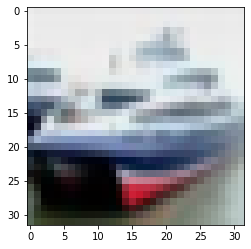

716

In [26]:
pixel(x_test[1],y_test[1])

In [27]:
for i in range(32*32):
  wrong_class = 0
  tablepred = adversarial_trained.predict(np.reshape(x_test[1],[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False) 
  pred = np.argmax(tablepred,axis =1 )[0]
  if(pred!=np.argmax(y_test[1])):
    print('YOUPI')
    #plt.imshow(testpix.reshape((32,32,3)))      
    print(labels[pred])
    wrong_class +=1
print(wrong_class)

0
